# Search and Query Knowledge Graphs

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Search" data-toc-modified-id="Search-1">Search</a></span></li>
        <li><span><a href="#Query" data-toc-modified-id="Query-2">Query</a></span></li>
        <li><span><a href="#Using-Results" data-toc-modified-id="Using-Results-3">Using Results</a></span></li>
    </ul>
</div>

There are a couple different ways to access the data of the knowledge graph. `search` provides results based on a full-text search string. `query` provides results based on an openCypher query string. The goal of this guide is to provide examples of various searches and queries that could be performed on a knowledge graph.

## Search

Searching the knowledge graph reaches out to the [search endpoint](https://developers.arcgis.com/rest/services-reference/enterprise/kgs-graph-search.htm) which searches for the given string on any properties of both entities or relationships by default. To search for properties on only entities or only relationships you can use the `category` parameter on `search` and set the value to either `entities`, `relationships`, or `both` (default).

In [ ]:
knowledge_graph.search("Esri", category="entities")

These results are in the form of a list of lists such as:
```
[
   [{'_objectType': 'entity',
   '_typeName': 'Company',
   '_id': UUID('f54c49c5-0aff-49ad-b38d-883b1323c709'),
   '_properties': {
      'globalid': UUID('f54c49c5-0aff-49ad-b38d-883b1323c709'),
      'objectid': 2,
      'name': 'Esri'
      }
   }]
]
```

Search uses Lucene syntax, which allows for more advanced searches such as using a wildcard (*), searching a specific property (name:Esri), and boolean operators like AND and OR. For more information about Lucene syntax, [see the syntax guide from Apache](https://lucene.apache.org/core/2_9_4/queryparsersyntax.html).

## Query

Querying the knowledge graph reaches out to the [query endpoint](https://developers.arcgis.com/rest/services-reference/enterprise/kgs-graph-query.htm) which runs the openCypher query on the graph and provides the results.

In [ ]:
knowledge_graph.query("MATCH (n) RETURN n LIMIT 2")

These results are in the form of a list of lists, such as:
```
[
   [{'_objectType': 'entity',
   '_typeName': 'Person',
   '_id': UUID('33c1915e-2169-4a95-b07a-b141fc684a39'),
   '_properties': {
      'globalid': UUID('33c1915e-2169-4a95-b07a-b141fc684a39'),
      'objectid': 1,
      'name': 'Megan'
      }
   }],
   [{'_objectType': 'entity',
   '_typeName': 'Company',
   '_id': UUID('f54c49c5-0aff-49ad-b38d-883b1323c709'),
   '_properties': {
      'globalid': UUID('f54c49c5-0aff-49ad-b38d-883b1323c709'),
      'objectid': 2,
      'name': 'Esri'
      }
   }]
]
```

## Using Results

Query responses can get much more complex depending on what is returned from the query. openCypher allows many different types of returns including entities, relationships, properties, anonymous objects, lists, and more. Providing this response as a list of lists guarantees the response can be used once returned.

If entities are returned that have a shape (are spatial) it can be useful to view the results of that query in a map. To do so, you can create a data frame from the properties in the results and spatially enable that data frame using the shape field to plot it on a map.


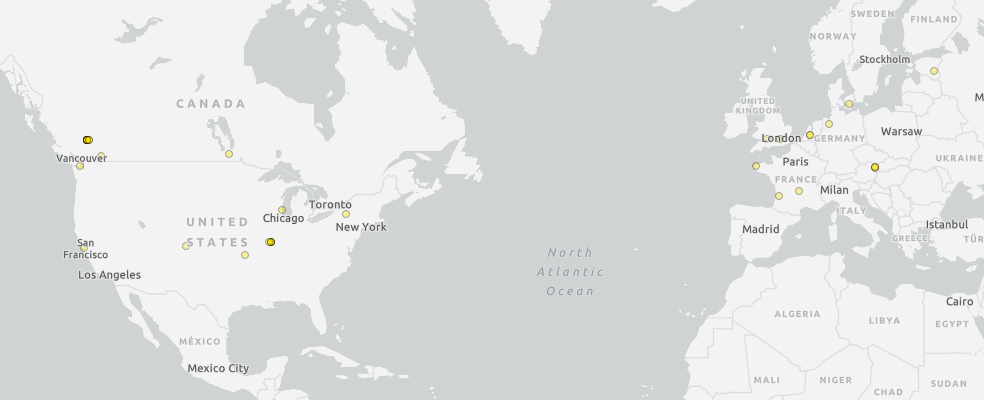

In [3]:
import pandas as pd

# openCypher query matches all entities (assume all entities returned are spatial for this example, OneType represents returning entities of a single type)
query_results = knowledge_graph.query("MATCH (n:OneType) RETURN n")

# create a list of all properties of the type to use as columns of our data frame
props_list = []
for prop in query_results[0][0]['_properties']:
    props_list.append(prop)

# iterate through the results of the query, writing those results to a list to be used in the data frame
results_list = []
for result in query_results:
    single_result = []
    # write each property value to a list
    for prop in props_list:
        single_result.append(result[0]['_properties'][prop])
    # append the list of properties to the data list
    results_list.append(single_result)

# create a data frame that holds all properties of the observation entities
obs_df = pd.DataFrame(data=results_list, columns=props_list)
# set the spatial column to shape
obs_df.spatial.set_geometry('shape')

# create a map of the results
new_map = gis.map()
new_map.basemap = 'gray-vector'
obs_df.spatial.plot(map_widget=new_map, renderer_type='s', marker_size=5, symbol_type='simple', colors=[252,226,5,90], outline_color=[0,0,0,90], line_width=0.5)
new_map